### Task 1: 4-point OCP

In [1]:
import gepetuto.magic
import crocoddyl
import pinocchio as pin
import numpy as np
import example_robot_data as robex
import matplotlib.pylab as plt
import time
import mim_solvers

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide
    the solutions to some questions. Change it for %load if you want to see (and
    execute) the solution.


In [2]:
# First, let's load the Pinocchio model for the Panda arm.
robot = robex.load('panda')
# The 2 last joints are for the fingers, not important in arm motion, freeze them
robot.model,[robot.visual_model,robot.collision_model] = \
    pin.buildReducedModel(robot.model,[robot.visual_model,robot.collision_model],[8,9],robot.q0)
robot.q0 = robot.q0[:7].copy()

In [3]:
TIME_STEP = 1e-2
FRAME_TIP = robot.model.getFrameId("panda_hand_tcp")
GOAL_POSITION = np.array([[.4, .4, 0], [.4, 0, 0], [.4, 0, .4], [.4, .4, .4]])
GOAL_PLACEMENT = [
    pin.SE3(pin.utils.rpyToMatrix(-np.pi, -1.5, 1.5), GOAL_POSITION[0]),
    pin.SE3(pin.utils.rpyToMatrix(-np.pi, -1.5, 1.5), GOAL_POSITION[1]),
    pin.SE3(pin.utils.rpyToMatrix(-np.pi, -1.5, 1.5), GOAL_POSITION[2]),
    pin.SE3(pin.utils.rpyToMatrix(-np.pi, -1.5, 1.5), GOAL_POSITION[3])
]

REACH_DIMENSION = "3d" # "6d"

In [4]:
# Set robot model
robot_model = robot.model
robot_model.armature = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.])*5
robot_model.q0 = np.array([0,-0.8,0,-2.4,0,1.57,0.8])
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])

In [5]:
from supaero2025.meshcat_viewer_wrapper import MeshcatVisualizer
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
viz.addBox('world/goal1',[.1,.1,.1],[0,1,0,1])
viz.applyConfiguration('world/goal1',GOAL_PLACEMENT[1])
viz.addBox('world/goal2',[.1,.1,.1],[0,0,1,1])
viz.applyConfiguration('world/goal2',GOAL_PLACEMENT[0])
viz.addBox('world/goal3',[.1,.1,.1],[1,0,0,1])
viz.applyConfiguration('world/goal3',GOAL_PLACEMENT[3])
viz.addBox('world/goal4',[.1,.1,.1],[1,1,0,1])
viz.applyConfiguration('world/goal4',GOAL_PLACEMENT[2])

viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [6]:
state = crocoddyl.StateMultibody(robot_model)

runningCostModel = [crocoddyl.CostModelSum(state),crocoddyl.CostModelSum(state),crocoddyl.CostModelSum(state),crocoddyl.CostModelSum(state)]
terminalCostModel = [crocoddyl.CostModelSum(state),crocoddyl.CostModelSum(state),crocoddyl.CostModelSum(state),crocoddyl.CostModelSum(state)]
actuationModel = crocoddyl.ActuationModelFull(state)

# Cost for 3d tracking || p(q) - pref ||**2
goalTrackingRes = [
    crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,GOAL_POSITION[0]),
    crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,GOAL_POSITION[1]),
    crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,GOAL_POSITION[2]),
    crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,GOAL_POSITION[3])
]
goalTrackingWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1]))

In [7]:
goalTrackingCost = [
    crocoddyl.CostModelResidual(state,goalTrackingWeights,goalTrackingRes[0]),
    crocoddyl.CostModelResidual(state,goalTrackingWeights,goalTrackingRes[1]),
    crocoddyl.CostModelResidual(state,goalTrackingWeights,goalTrackingRes[2]),
    crocoddyl.CostModelResidual(state,goalTrackingWeights,goalTrackingRes[3])
]

runningCostModel[0].addCost("gripperPose", goalTrackingCost[0], 30)
terminalCostModel[0].addCost("gripperPose", goalTrackingCost[0], 1000)
runningCostModel[1].addCost("gripperPose", goalTrackingCost[1], 7)
terminalCostModel[1].addCost("gripperPose", goalTrackingCost[1], 50)
runningCostModel[2].addCost("gripperPose", goalTrackingCost[2], 1)
terminalCostModel[2].addCost("gripperPose", goalTrackingCost[2], 10)
runningCostModel[3].addCost("gripperPose", goalTrackingCost[3], .001)
terminalCostModel[3].addCost("gripperPose", goalTrackingCost[3], 4)

In [8]:
# Regularization is stronger on position than velocity (to account for typical unit scale)
xRegWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, .1,.1,.1,.1,.1,.1,.1]))
xRegRes = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCost = crocoddyl.CostModelResidual(state,xRegWeights,xRegRes)
for i in range(4):
    runningCostModel[i].addCost("xReg", xRegCost, 1e-3)

# Terminal cost for state regularization || x - x* ||**2
# Require more strictly a small velocity at task end (but we don't car for the position)
xRegWeightsT=crocoddyl.ActivationModelWeightedQuad(np.array([.5,.5,.5,.5,.5,.5,.5,  5.,5.,5.,5.,5.,5.,5.]))
xRegResT = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCostT = crocoddyl.CostModelResidual(state,xRegWeightsT,xRegResT)
for i in range(4):
    terminalCostModel[i].addCost("xReg", xRegCostT, .01)

In [9]:
# %load tp5/generated/panda_reaches_a_single_target_cost_ureg
# Cost for control regularization || u - g(q) ||**2
uRegRes = crocoddyl.ResidualModelControlGrav(state)
uRegCost = crocoddyl.CostModelResidual(state,uRegRes)

for i in range(4):
    runningCostModel[i].addCost("uReg", uRegCost, 1e-4)

In [10]:
runningModels = [0,0,0,0]
terminalModels = [0,0,0,0]
for i in range(4):
    runningModels[i] = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel[i]), TIME_STEP)
    runningModels[i].differential.armature = robot_model.armature
    # Terminal model following the same logic, although the integration is here trivial.
    terminalModels[i] = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel[i]), 0.)
    terminalModels[i].differential.armature = robot_model.armature

T = 100
HORIZON_LENGTH = T*4
x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])


In [11]:
seq0 = [runningModels[0]]*T + [terminalModels[0]]
seq1 = [runningModels[1]]*T + [terminalModels[1]]
seq2 = [runningModels[2]]*T + [terminalModels[2]]
seq3 = [runningModels[3]]*T 
# problem = crocoddyl.ShootingProblem(x0,seq0+seq1+seq2+seq3,terminalModels[3])
problem = crocoddyl.ShootingProblem(x0,seq0+seq1+seq2+seq3,terminalModels[3])

In [12]:
solver = mim_solvers.SolverCSQP(problem)
solver.with_callbacks = True 
solver.termination_tolerance = 1e-3         # Termination criteria (KKT residual)
solver.max_qp_iters = 1000                  # Maximum number of QP iteration
solver.eps_abs = 1e-5                       # QP termination absolute criteria, 1e-9 
solver.eps_rel = 0.                         # QP termination absolute criteria
solver.use_filter_line_search = True        # True by default, False = use merit function

solver.solve([],[],1000)  # xs_init,us_init,maxiter

True

In [13]:
viz.viewer.jupyter_cell()

In [14]:
viz.play([x[:robot.model.nq] for x in solver.xs],TIME_STEP)

### Task 2: Adding bounds (virtual walls)

In [15]:
# %load tp5/generated/panda_reaches_with_constraints_hyperparameters
X_WALL_LOWER = -np.inf
X_WALL_UPPER = np.inf
Y_WALL_LOWER = -0.2
Y_WALL_UPPER = 0.6
Z_WALL_LOWER = -0.2
Z_WALL_UPPER = 0.6

In [16]:
runningConstraints = crocoddyl.ConstraintModelManager(state, robot.nv)

frameTranslationResidual = crocoddyl.ResidualModelFrameTranslation(
    state, FRAME_TIP, np.zeros(3)
)
eeWallContraint = crocoddyl.ConstraintModelResidual(
    state,
    frameTranslationResidual,
    np.array([X_WALL_LOWER, Y_WALL_LOWER, Z_WALL_LOWER]),
    np.array([X_WALL_UPPER, Y_WALL_UPPER, Z_WALL_UPPER]),
)
runningConstraints.addConstraint("ee_wall", eeWallContraint)

In [17]:
runningModel_constrained = [0,0,0,0]

for i in range(4):
    runningModel_constrained[i] = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(
            state, actuationModel, runningCostModel[i], runningConstraints),
            TIME_STEP
        )
    runningModel_constrained[i].differential.armature = robot_model.armature

runningModel_init = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel[0]),
        TIME_STEP
    )
runningModel_init.differential.armature = robot_model.armature

In [18]:
seq0 = [runningModel_constrained[0]]*T + [terminalModels[0]]
seq1 = [runningModel_constrained[1]]*T + [terminalModels[1]]
seq2 = [runningModel_constrained[2]]*T + [terminalModels[2]]
seq3 = [runningModel_constrained[3]]*T 
problem = crocoddyl.ShootingProblem(
        robot_model.x0,
        [runningModel_init]*50+seq0+seq1+seq2+seq3,
        terminalModels[3]
    )

In [19]:
solver_2 = mim_solvers.SolverCSQP(problem)
solver_2.with_callbacks = True 
solver_2.termination_tolerance = 1e-3         # Termination criteria (KKT residual)
solver_2.max_qp_iters = 100                   # Maximum number of QP iteration
solver_2.eps_abs = 1e-5                       # QP termination absolute criteria, 1e-9 
solver_2.eps_rel = 0.                         # QP termination absolute criteria
solver_2.use_filter_line_search = True        # True by default, False = use merit function

solver_2.solve([],[],1000)  # xs_init,us_init,maxiter

True

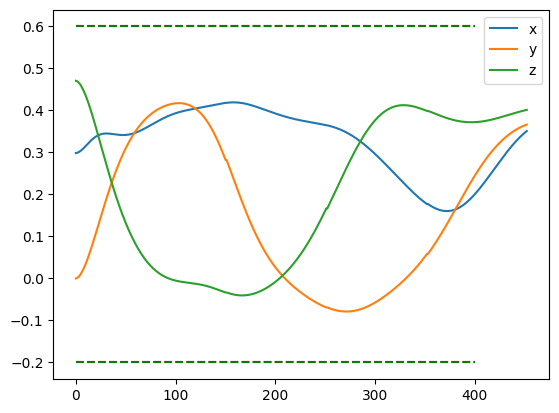

In [20]:
ees = [ d.differential.pinocchio.oMf[FRAME_TIP].translation for d in solver_2.problem.runningDatas ]
plt.plot(ees)
plt.plot([0,HORIZON_LENGTH],[X_WALL_UPPER,X_WALL_UPPER],'b--')
plt.plot([0,HORIZON_LENGTH],[X_WALL_LOWER,X_WALL_LOWER],'b--')
plt.plot([0,HORIZON_LENGTH],[Y_WALL_UPPER,Y_WALL_UPPER],'r--')
plt.plot([0,HORIZON_LENGTH],[Y_WALL_LOWER,Y_WALL_LOWER],'r--')
plt.plot([0,HORIZON_LENGTH],[Z_WALL_UPPER,Z_WALL_UPPER],'g--')
plt.plot([0,HORIZON_LENGTH],[Z_WALL_LOWER,Z_WALL_LOWER],'g--')
plt.legend(['x', 'y', 'z'])

In [21]:
viz.viewer.jupyter_cell()

In [22]:
viz.play([x[:robot.model.nq] for x in solver_2.xs],TIME_STEP) 

### Task 3: Replacing targets as hard constraints instead of costs

In [23]:
terminalConstraints = [0,0,0,0]

for i in range(4):

    terminalConstraints[i] = crocoddyl.ConstraintModelManager(state, robot.nv)
    target_position = GOAL_POSITION[i]

    frameTranslationResidual = crocoddyl.ResidualModelFrameTranslation(
        state, FRAME_TIP, target_position
    )

    passThroughContraint = crocoddyl.ConstraintModelResidual(
        state,
        frameTranslationResidual,
        np.zeros(3),  # Lower bound
        np.zeros(3),  # Upper bound
    )
    
    terminalConstraints[i].addConstraint("pass_through", passThroughContraint)

In [24]:
lower_joint_limits, upper_joint_limits = robot_model.lowerPositionLimit, robot_model.upperPositionLimit

# 2. Create a zero reference state (residual compares x - x_ref)
x_ref = state.zero()
residual = crocoddyl.ResidualModelState(state, x_ref)

# 3. Create full bounds of size `ndx` (dimension of tangent space)
lb = np.full(state.ndx, -np.inf)
ub = np.full(state.ndx,  np.inf)

joint_idx = slice(0, state.nq)  # first part is for configuration

lb[joint_idx] = lower_joint_limits
ub[joint_idx] = upper_joint_limits

# 4. Create activation model and constraint model
activation_bounds = crocoddyl.ActivationBounds(lb, ub)
activation_model = crocoddyl.ActivationModelQuadraticBarrier(activation_bounds)

joint_limit_constraint = crocoddyl.ConstraintModelResidual(
    state,
    residual,
    lb,
    ub
)

runningConstraints.addConstraint("joint_limits", joint_limit_constraint)


In [25]:
runningModel_constrained = [0,0,0,0]

for i in range(4):
    runningCostModel[i].removeCost("gripperPose")
    runningModel_constrained[i] = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(
            state, actuationModel, runningCostModel[i], runningConstraints),
            TIME_STEP
        )
    runningModel_constrained[i].differential.armature = robot_model.armature

runningModel_init = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel[0]),
        TIME_STEP
    )
runningModel_init.differential.armature = robot_model.armature

In [26]:
terminalModel_constrained = [0,0,0,0]
for i in range(4):
    terminalModel_constrained[i] = crocoddyl.IntegratedActionModelEuler(
        crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel[i], terminalConstraints[i]), 0.)
    terminalModel_constrained[i].differential.armature = robot_model.armature


In [27]:
seq0 = [runningModel_constrained[0]]*T + [terminalModel_constrained[0]]
seq1 = [runningModel_constrained[1]]*T + [terminalModel_constrained[1]]
seq2 = [runningModel_constrained[2]]*T + [terminalModel_constrained[2]]
seq3 = [runningModel_constrained[3]]*T 
problem = crocoddyl.ShootingProblem(
        robot_model.x0,
        [runningModel_init]*50+seq0+seq1+seq2+seq3,
        terminalModel_constrained[3]
    )

In [28]:
solver_3 = mim_solvers.SolverCSQP(problem)
solver_3.with_callbacks = True 
solver_3.termination_tolerance = 1e-3         # Termination criteria (KKT residual)
solver_3.max_qp_iters = 1000                   # Maximum number of QP iteration
solver_3.eps_abs = 1e-5                       # QP termination absolute criteria, 1e-9 
solver_3.eps_rel = 0.                         # QP termination absolute criteria
solver_3.use_filter_line_search = True        # True by default, False = use merit function

solver_3.solve([],[],1000)  # xs_init,us_init,maxiter

False

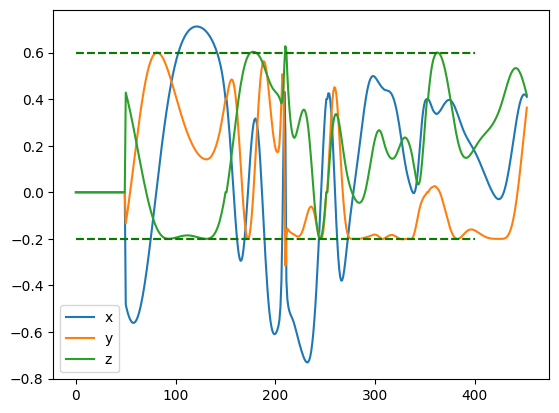

In [29]:
ees = [ d.differential.pinocchio.oMf[FRAME_TIP].translation for d in solver_3.problem.runningDatas ]
plt.plot(ees)
plt.plot([0,HORIZON_LENGTH],[X_WALL_UPPER,X_WALL_UPPER],'b--')
plt.plot([0,HORIZON_LENGTH],[X_WALL_LOWER,X_WALL_LOWER],'b--')
plt.plot([0,HORIZON_LENGTH],[Y_WALL_UPPER,Y_WALL_UPPER],'r--')
plt.plot([0,HORIZON_LENGTH],[Y_WALL_LOWER,Y_WALL_LOWER],'r--')
plt.plot([0,HORIZON_LENGTH],[Z_WALL_UPPER,Z_WALL_UPPER],'g--')
plt.plot([0,HORIZON_LENGTH],[Z_WALL_LOWER,Z_WALL_LOWER],'g--')
plt.legend(['x', 'y', 'z'])

In [30]:
viz.viewer.jupyter_cell()

In [34]:
viz.play([x[:robot.model.nq] for x in solver_3.xs],TIME_STEP) 

In [35]:
model = robot_model
data = model.createData()
frame_id = model.getFrameId("panda_hand_tcp") 

for t, x in enumerate(solver_3.xs):
    q = x[:state.nq]
    print(f"t = {t}: {q}")
    # pin.forwardKinematics(model, data, q)
    # pin.updateFramePlacements(model, data)
    # ee_pos = data.oMf[frame_id].translation
    # print(f"t = {t}: EE position = {ee_pos}")



t = 0: [ 0.   -0.8   0.   -2.4   0.    1.57  0.8 ]
t = 1: [-1.31920069e-03 -8.00746886e-01 -1.17191709e-03 -2.39958734e+00
 -8.00019041e-04  1.56976715e+00  7.96146461e-01]
t = 2: [-3.93347765e-03 -8.02224030e-01 -3.49481463e-03 -2.39876358e+00
 -2.38809186e-03  1.56931024e+00  7.91784743e-01]
t = 3: [-0.00782036 -0.80441377 -0.00694904 -2.39753055 -0.00475214  1.56863787
  0.78770193]
t = 4: [-0.01295782 -0.80729752 -0.01151543 -2.39589007 -0.00788005  1.56775866
  0.78404513]
t = 5: [-0.01932393 -0.81085582 -0.01717507 -2.39384396 -0.01175965  1.56668139
  0.78080091]
t = 6: [-0.02689681 -0.81506842 -0.02390926 -2.39139404 -0.01637878  1.56541493
  0.77791526]
t = 7: [-0.03565453 -0.8199143  -0.03169945 -2.38854212 -0.02172521  1.5639683
  0.77532375]
t = 8: [-0.04557512 -0.82537172 -0.04052731 -2.38529002 -0.02778674  1.56235062
  0.77295923]
t = 9: [-0.05663652 -0.8314183  -0.05037465 -2.38163962 -0.03455113  1.56057112
  0.77075389]
t = 10: [-0.06881651 -0.83803103 -0.06122343 -2.

### Task 4 - Applying joint limits